# Multi-domain adversarial Neural Network (MDANN) for GE Data

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from math import exp
from math import pi
import matplotlib.pyplot as plt

import numpy as np
import pickle as pkl

import tensorflow as tf

from sklearn.datasets import make_moons, make_blobs
from sklearn.decomposition import PCA

Check if GPU is present and if tensorflow sees it.

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11067856030893009973, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6614766059
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8255963455328223216
 physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

Generate synthetic Gaussian blob data for binary classifications. Synthetic "domains" are generated by rotating the two Gaussian blobs through an angle and dilating them.

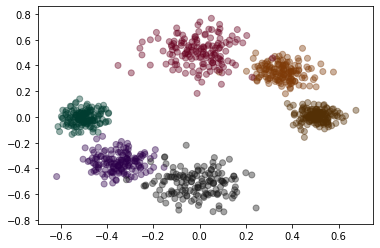

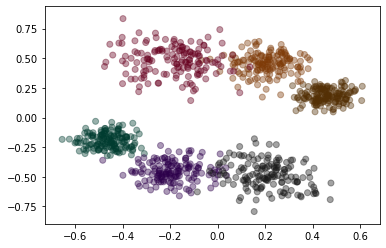

In [28]:
num_domains_train = 3
num_domains_test = 3
num_data = 300
X_train = np.zeros((num_data*num_domains_train, 2))
y_train = np.zeros((num_data*num_domains_train, 2), dtype = int)
D_train = np.zeros((num_data*num_domains_train, num_domains_train), dtype = int)
X_test = np.zeros((num_data*num_domains_test, 2))
y_test = np.zeros((num_data*num_domains_test, 2), dtype = int)
D_test = np.zeros((num_data*num_domains_test, num_domains_test), dtype = int)
cmap_list = ['BrBG', 'PuOr', 'RdGy']

for i in range(num_domains_train):
    x_blob1 = 0.5*np.cos(i*pi/4.0)
    y_blob1 = 0.5*np.sin(i*pi/4.0)
    x_blob2 = 0.5*np.cos(i*pi/4.0 + pi)
    y_blob2 = 0.5*np.sin(i*pi/4.0 + pi)
    std = 0.05*(0.5*i+1)
    Xs, ys = make_blobs(num_data, centers = [[x_blob1, y_blob1], [x_blob2, y_blob2]], cluster_std = std)
    plt.scatter(Xs[:,0], Xs[:,1], c = ys, cmap = cmap_list[i], alpha = 0.4)

plt.show()

for i in range(num_domains_test):
    x_blob1 = 0.5*np.cos((i+0.5)*pi/4.0)
    y_blob1 = 0.5*np.sin((i+0.5)*pi/4.0)
    x_blob2 = 0.5*np.cos((i+0.5)*pi/4.0 + pi)
    y_blob2 = 0.5*np.sin((i+0.5)*pi/4.0 + pi)
    std = 0.05*(0.5*(i+0.5)+1)
    Xs, ys = make_blobs(num_data, centers = [[x_blob1, y_blob1], [x_blob2, y_blob2]], cluster_std = std)
    Xt, yt = make_blobs(num_data//5, centers = [[x_blob1, y_blob1], [x_blob2, y_blob2]], cluster_std = std)
    plt.scatter(Xs[:,0], Xs[:,1], c = ys, cmap = cmap_list[i], alpha = 0.4)

plt.show()

Implement gradient reversal layer in TF.

In [ ]:
class FlipGradientBuilder(object):
    def __init__(self):
        self.num_calls = 0

    def __call__(self, x, l=1.0):
        grad_name = "FlipGradient%d" % self.num_calls
        @ops.RegisterGradient(grad_name)
        def _flip_gradients(op, grad):
            return [tf.negative(grad) * l]
        
        g = tf.get_default_graph()
        with g.gradient_override_map({"Identity": grad_name}):
            y = tf.identity(x)
            
        self.num_calls += 1
        return y
    
flip_gradient = FlipGradientBuilder()

In [ ]:
batch_size = 16
hidden_size_f1 = 15
def build_model():
    X = tf.placeholder(tf.float32, [None, 2], name='X') # Input data
    Y = tf.placeholder(tf.int32, [None, 2], name='Y_ind')  # Class
    D = tf.placeholder(tf.int32, [None, num_domains], name='D_ind')  # Domain
    l = tf.placeholder(tf.float32, [], name='l') # Gradient reversal scaler

    # Feature extractor - double layer
    layer_f1 = tf.layers.Dense(hidden_size_f1, activation=tf.nn.selu,
                               kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f1_w),
                               bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f1_b))
    F_mid = layer_f1.apply(X)
    layer_f1 = tf.layers.Dense(hidden_size_f2, activation=tf.nn.selu,
                               kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f1_w),
                               bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_f1_b))
    F = layer_f2.apply(F_mid)

    # Label predictor - single layer

    W1 = weight_variable([15, 2])
    b1 = bias_variable([2])
    p_logit = tf.matmul(f, W1) + b1
    p = tf.nn.softmax(p_logit)
    p_loss = tf.nn.softmax_cross_entropy_with_logits(logits=p_logit, labels=y)

    # Domain predictor - shallow
    f_ = flip_gradient(F, l)

    if shallow_domain_classifier:
        W2 = weight_variable([15, 2])
        b2 = bias_variable([2])
        d_logit = tf.matmul(f_, W2) + b2
        d = tf.nn.softmax(d_logit)
        d_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D)

    else:
        W2 = weight_variable([15, 8])
        b2 = bias_variable([8])
        h2 = tf.nn.relu(tf.matmul(f_, W2) + b2)

        W3 = weight_variable([8, 2])
        b3 = bias_variable([2])
        d_logit = tf.matmul(h2, W3) + b3
        d = tf.nn.softmax(d_logit)
        d_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logit, labels=D)


    # Optimization
    pred_loss = tf.reduce_sum(p_loss, name='pred_loss')
    domain_loss = tf.reduce_sum(d_loss, name='domain_loss')
    total_loss = tf.add(pred_loss, domain_loss, name='total_loss')

    pred_train_op = tf.train.AdamOptimizer().minimize(pred_loss, name='pred_train_op')
    domain_train_op = tf.train.AdamOptimizer().minimize(domain_loss, name='domain_train_op')
    dann_train_op = tf.train.AdamOptimizer().minimize(total_loss, name='dann_train_op')

    # Evaluation
    p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(p, 1)), tf.float32), name='p_acc')
    d_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(D, 1), tf.argmax(d, 1)), tf.float32), name='d_acc')